In [1]:
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from osgeo import osr, ogr, gdal
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 

import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Параметры
path_train = "files 3/train_3.png" 
path_target = "files 3/target_3.png" 

size = 32

In [33]:
def split_image(path, size, save_path=None):
    img = Image.open(path).convert('L') 
    x, y = img.size  # ширина (x) и высота (y) изображения

    x = x // size
    y = y // size

    all = [] 

    for i in tqdm(range(x)):
        for j in range(y): 
            mini_image = img.crop(box=(size * i, size * j, size * (i + 1), size * ( j + 1)))
            if save_path:
                mini_image.save(save_path + 'image{}.png'.format(str(j + i*y)))

            mini_image = np.array(mini_image.getdata())
            mini_image = np.reshape(mini_image, (1, size, size, 1)) 

            if len(all) == 0:
                all =  mini_image
            else:
                all = np.append(all, mini_image, axis=0) 
    print(np.shape(all)) 
    return all, [x, y]

In [34]:
target, target_size = split_image(path_target, size) #, "files 3/target_spilted/")

100%|██████████| 27/27 [00:00<00:00, 167.79it/s]

(378, 32, 32, 1)


In [36]:
train, train_size = split_image(path_train, size)#, "files 3/train_spilted/")

100%|██████████| 27/27 [00:00<00:00, 178.31it/s]

(378, 32, 32, 1)


In [17]:
train.max()

192

In [35]:
target.max()

255

In [37]:
target = target / 255.0 
# target = (target / 127.5) - 1 
train = train / train.max()
# train = train / (train.max() / 2) - 1 

In [38]:
target = np.reshape(target, (-1, size*size)) 

In [67]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        7232      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 130)               5326

In [13]:
# class ComputeSum(keras.layers.Layer):
#     def __init__(self, input_dim):
#         super(ComputeSum, self).__init__()
#         self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

#     def call(self, inputs):
#         self.total.assign_add(tf.reduce_sum(inputs, axis=0))
#         return self.total

In [137]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):        
        
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=keras.initializers.Constant(value=100),
            trainable=False,
        ) 
        
#         self.w = np.array([100] *input_shape[-1] )
#         self.w = np.reshape(self.w, (-1, 1))

    def call(self, inputs):
#         print(self.w.value())
        return tf.matmul(inputs, self.w)  


In [127]:
model.layers


In [136]:
first_layer_weights = model.layers[6].get_weights()
first_layer_weights

[]

In [105]:
len(model.layers)

9

In [27]:
inp = Input(shape=(size, size, 1))
x = Conv2D(256, (15,15), padding='same', activation=tf.nn.relu) (inp)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Conv2D(128, (9,9), padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Conv2D(90, (7,7), padding='same', activation=tf.nn.relu)(x)
x = MaxPooling2D((2, 2), strides=2)(x)
x = Flatten()(x)
x = Dense(130, activation=tf.nn.selu)(x) 
x = Dropout(0.5)(x)
x = Dense(130, activation=tf.nn.selu)(x) 
x = Dropout(0.5)(x)

out = Dense(size*size,  activation=tf.nn.softmax)(x)
model = Model(inputs=inp, outputs=out)

In [21]:
model = Sequential([
    Conv2D(512, (5,5), padding='same', activation=tf.nn.relu,
                           input_shape=(size, size, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(256, (5,5), padding='same', activation=tf.nn.relu), 
    MaxPooling2D((2, 2), strides=2),
    Conv2D(128, (5,5), padding='same', activation=tf.nn.relu), 
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(130, activation=tf.nn.relu),
#     Linear(),
    Dense(130, activation=tf.nn.relu),
    Dense(size*size,  activation=tf.nn.softmax)
])


In [87]:
# model = Sequential([
#     Conv2D(128, (9,9), padding='same', activation=tf.nn.relu,
#                            input_shape=(size, size, 1)),
#     MaxPooling2D((2, 2), strides=2),
#     Conv2D(256, (9,9), padding='same', activation=tf.nn.relu), 
#     MaxPooling2D((2, 2), strides=2),
#     Flatten(),
#     Dense(130, activation=tf.nn.relu),
#     Dense(130, activation=tf.nn.relu),
#     Dense(size*size,  activation=tf.nn.softmax)
# ])


In [48]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)


In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',       # categorical_crossentropy
              metrics=['accuracy'])

In [29]:
his = model.fit(train, target, epochs=7000)

Epoch 1/7000
12/12 [==============================] - 3s 58ms/step - loss: 0.1416 - accuracy: 0.0000e+00
Epoch 2/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.1602 - accuracy: 0.0000e+00
Epoch 3/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1237 - accuracy: 0.0018
Epoch 4/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1082 - accuracy: 0.0000e+00
Epoch 5/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1174 - accuracy: 0.0014
Epoch 6/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1416 - accuracy: 0.0000e+00
Epoch 7/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1101 - accuracy: 0.0000e+00
Epoch 8/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1276 - accuracy: 0.0014
Epoch 9/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1060 - accuracy: 0.0000e+00
Epoch 10/7000
12/12 [==============================] - 1s 47ms/step

12/12 [==============================] - 1s 47ms/step - loss: 0.0858 - accuracy: 0.0053
Epoch 80/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0962 - accuracy: 0.0027
Epoch 81/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1016 - accuracy: 0.0000e+00
Epoch 82/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0684 - accuracy: 0.0044
Epoch 83/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0800 - accuracy: 0.0000e+00
Epoch 84/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0950 - accuracy: 0.0032
Epoch 85/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1234 - accuracy: 0.0103
Epoch 86/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0765 - accuracy: 0.0027
Epoch 87/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0734 - accuracy: 8.6592e-04
Epoch 88/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0628 -

12/12 [==============================] - 1s 47ms/step - loss: 0.0906 - accuracy: 0.0041
Epoch 159/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0898 - accuracy: 0.0101
Epoch 160/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0907 - accuracy: 0.0033
Epoch 161/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0831 - accuracy: 0.0000e+00
Epoch 162/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0752 - accuracy: 0.0000e+00
Epoch 163/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0777 - accuracy: 0.0054
Epoch 164/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1240 - accuracy: 0.0063
Epoch 165/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0896 - accuracy: 0.0010
Epoch 166/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0950 - accuracy: 0.0000e+00
Epoch 167/7000
12/12 [==============================] - 1s 47ms/step - loss:

Epoch 237/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0856 - accuracy: 0.0041
Epoch 238/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1117 - accuracy: 0.0000e+00
Epoch 239/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1082 - accuracy: 8.6592e-04
Epoch 240/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1217 - accuracy: 0.0018
Epoch 241/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1034 - accuracy: 0.0013
Epoch 242/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0746 - accuracy: 0.0041
Epoch 243/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0940 - accuracy: 0.0073
Epoch 244/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0795 - accuracy: 0.0000e+00
Epoch 245/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0917 - accuracy: 0.0000e+00
Epoch 246/7000
12/12 [==============================] - 1

12/12 [==============================] - 1s 47ms/step - loss: 0.0877 - accuracy: 0.0000e+00
Epoch 316/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1131 - accuracy: 0.0050
Epoch 317/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0958 - accuracy: 0.0000e+00
Epoch 318/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0616 - accuracy: 0.0041
Epoch 319/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1051 - accuracy: 0.0066
Epoch 320/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0768 - accuracy: 0.0039
Epoch 321/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1381 - accuracy: 0.0123
Epoch 322/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0829 - accuracy: 0.0146
Epoch 323/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0818 - accuracy: 0.0014
Epoch 324/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1

12/12 [==============================] - 1s 47ms/step - loss: 0.0796 - accuracy: 0.0049
Epoch 394/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0943 - accuracy: 0.0033
Epoch 395/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1251 - accuracy: 0.0000e+00
Epoch 396/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1291 - accuracy: 6.2553e-04
Epoch 397/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0801 - accuracy: 0.0083
Epoch 398/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0790 - accuracy: 0.0077
Epoch 399/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1147 - accuracy: 0.0033
Epoch 400/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0732 - accuracy: 0.0000e+00
Epoch 401/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0862 - accuracy: 0.0048
Epoch 402/7000
12/12 [==============================] - 1s 47ms/step - loss:

12/12 [==============================] - 1s 47ms/step - loss: 0.0729 - accuracy: 0.0135
Epoch 472/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0827 - accuracy: 0.0033
Epoch 473/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0955 - accuracy: 0.0102
Epoch 474/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1133 - accuracy: 0.0172
Epoch 475/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1015 - accuracy: 0.0027
Epoch 476/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0753 - accuracy: 0.0064
Epoch 477/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0946 - accuracy: 0.0153
Epoch 478/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0972 - accuracy: 0.0041
Epoch 479/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1066 - accuracy: 0.0108
Epoch 480/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0596 - ac

Epoch 550/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0638 - accuracy: 0.0026
Epoch 551/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0898 - accuracy: 0.0067
Epoch 552/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0938 - accuracy: 0.0150
Epoch 553/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1018 - accuracy: 0.0000e+00
Epoch 554/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0802 - accuracy: 0.0041
Epoch 555/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0988 - accuracy: 0.0124
Epoch 556/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0875 - accuracy: 0.0029
Epoch 557/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0973 - accuracy: 0.0000e+00
Epoch 558/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1054 - accuracy: 0.0047
Epoch 559/7000
12/12 [==============================] - 1s 47ms/s

12/12 [==============================] - 1s 48ms/step - loss: 0.0705 - accuracy: 0.0027
Epoch 629/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0964 - accuracy: 0.0000e+00
Epoch 630/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1012 - accuracy: 0.0064
Epoch 631/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0805 - accuracy: 0.0059
Epoch 632/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0893 - accuracy: 0.0258
Epoch 633/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0950 - accuracy: 0.0064
Epoch 634/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0916 - accuracy: 4.0700e-04
Epoch 635/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0988 - accuracy: 0.0032
Epoch 636/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1137 - accuracy: 0.0018
Epoch 637/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0

12/12 [==============================] - 1s 46ms/step - loss: 0.0803 - accuracy: 0.0053
Epoch 708/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0571 - accuracy: 4.0700e-04
Epoch 709/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1009 - accuracy: 0.0081
Epoch 710/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0916 - accuracy: 0.0066
Epoch 711/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0676 - accuracy: 0.0000e+00
Epoch 712/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0939 - accuracy: 0.0033
Epoch 713/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0820 - accuracy: 0.0105
Epoch 714/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1072 - accuracy: 0.0065
Epoch 715/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0912 - accuracy: 0.0053
Epoch 716/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0

12/12 [==============================] - 1s 46ms/step - loss: 0.0598 - accuracy: 0.0010
Epoch 786/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1083 - accuracy: 0.0100
Epoch 787/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0833 - accuracy: 0.0000e+00
Epoch 788/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0582 - accuracy: 0.0052
Epoch 789/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1008 - accuracy: 4.0700e-04
Epoch 790/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0945 - accuracy: 0.0046
Epoch 791/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1176 - accuracy: 0.0094
Epoch 792/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0872 - accuracy: 0.0000e+00
Epoch 793/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0799 - accuracy: 0.0055
Epoch 794/7000
12/12 [==============================] - 1s 47ms/step - loss:

12/12 [==============================] - 1s 47ms/step - loss: 0.0835 - accuracy: 0.0042
Epoch 864/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1295 - accuracy: 0.0070
Epoch 865/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1191 - accuracy: 0.0103
Epoch 866/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0782 - accuracy: 0.0000e+00
Epoch 867/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0667 - accuracy: 0.0000e+00
Epoch 868/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0721 - accuracy: 0.0052
Epoch 869/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1076 - accuracy: 0.0045
Epoch 870/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0711 - accuracy: 0.0077
Epoch 871/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0812 - accuracy: 0.0041
Epoch 872/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0

Epoch 942/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0718 - accuracy: 6.2553e-04
Epoch 943/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0704 - accuracy: 0.0039
Epoch 944/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1216 - accuracy: 0.0065
Epoch 945/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0900 - accuracy: 0.0117
Epoch 946/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1136 - accuracy: 0.0064
Epoch 947/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0713 - accuracy: 0.0068
Epoch 948/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1004 - accuracy: 0.0037
Epoch 949/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1126 - accuracy: 0.0032
Epoch 950/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0660 - accuracy: 6.2553e-04
Epoch 951/7000
12/12 [==============================] - 1s 47ms/s

12/12 [==============================] - 1s 48ms/step - loss: 0.0910 - accuracy: 0.0056
Epoch 1021/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0878 - accuracy: 0.0101
Epoch 1022/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0807 - accuracy: 0.0000e+00
Epoch 1023/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0802 - accuracy: 0.0020
Epoch 1024/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0891 - accuracy: 0.0000e+00
Epoch 1025/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1083 - accuracy: 0.0114
Epoch 1026/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0960 - accuracy: 0.0077
Epoch 1027/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0911 - accuracy: 0.0128
Epoch 1028/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0942 - accuracy: 0.0033
Epoch 1029/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 49ms/step - loss: 0.0718 - accuracy: 0.0014
Epoch 1099/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.1035 - accuracy: 4.0700e-04
Epoch 1100/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0724 - accuracy: 0.0041
Epoch 1101/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1072 - accuracy: 0.0027
Epoch 1102/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0818 - accuracy: 0.0014
Epoch 1103/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.1376 - accuracy: 0.0010
Epoch 1104/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0767 - accuracy: 0.0013
Epoch 1105/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0984 - accuracy: 0.0024
Epoch 1106/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1150 - accuracy: 0.0117
Epoch 1107/7000
12/12 [==============================] - 1s 49ms/step - loss

12/12 [==============================] - 1s 48ms/step - loss: 0.0904 - accuracy: 8.6592e-04
Epoch 1177/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0995 - accuracy: 4.0700e-04
Epoch 1178/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0995 - accuracy: 0.0129
Epoch 1179/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0997 - accuracy: 0.0000e+00
Epoch 1180/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0854 - accuracy: 0.0128
Epoch 1181/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0736 - accuracy: 0.0139
Epoch 1182/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1110 - accuracy: 0.0073
Epoch 1183/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0865 - accuracy: 8.6592e-04
Epoch 1184/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0941 - accuracy: 0.0221
Epoch 1185/7000
12/12 [==============================] - 1s 48ms

12/12 [==============================] - 1s 46ms/step - loss: 0.0764 - accuracy: 0.0011
Epoch 1255/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0870 - accuracy: 0.0029
Epoch 1256/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0804 - accuracy: 0.0085
Epoch 1257/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1230 - accuracy: 0.0041
Epoch 1258/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0736 - accuracy: 0.0093
Epoch 1259/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0705 - accuracy: 0.0041
Epoch 1260/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1092 - accuracy: 0.0117
Epoch 1261/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1076 - accuracy: 0.0022
Epoch 1262/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0685 - accuracy: 0.0000e+00
Epoch 1263/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.1154 - accuracy: 0.0020
Epoch 1333/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0908 - accuracy: 0.0053
Epoch 1334/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0922 - accuracy: 0.0070
Epoch 1335/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0821 - accuracy: 0.0085
Epoch 1336/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1008 - accuracy: 0.0033
Epoch 1337/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0756 - accuracy: 0.0029
Epoch 1338/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0711 - accuracy: 0.0000e+00
Epoch 1339/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0945 - accuracy: 0.0011
Epoch 1340/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0697 - accuracy: 0.0000e+00
Epoch 1341/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0689 - accuracy: 0.0151
Epoch 1411/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1029 - accuracy: 0.0144
Epoch 1412/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0870 - accuracy: 6.2553e-04
Epoch 1413/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.1194 - accuracy: 0.0022
Epoch 1414/7000
12/12 [==============================] - 1s 54ms/step - loss: 0.1071 - accuracy: 0.0088
Epoch 1415/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0914 - accuracy: 6.2553e-04
Epoch 1416/7000
12/12 [==============================] - 1s 51ms/step - loss: 0.0700 - accuracy: 0.0030
Epoch 1417/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.0619 - accuracy: 0.0000e+00
Epoch 1418/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0673 - accuracy: 0.0044
Epoch 1419/7000
12/12 [==============================] - 1s 54ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.1087 - accuracy: 0.0044
Epoch 1489/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0556 - accuracy: 0.0035
Epoch 1490/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0872 - accuracy: 0.0066
Epoch 1491/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1009 - accuracy: 0.0077
Epoch 1492/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0863 - accuracy: 0.0116
Epoch 1493/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0885 - accuracy: 0.0000e+00
Epoch 1494/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0746 - accuracy: 0.0037
Epoch 1495/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0917 - accuracy: 0.0015
Epoch 1496/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1156 - accuracy: 0.0018
Epoch 1497/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0882 - accuracy: 0.0041
Epoch 1567/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0689 - accuracy: 0.0023
Epoch 1568/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0867 - accuracy: 0.0027
Epoch 1569/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0871 - accuracy: 0.0000e+00
Epoch 1570/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0695 - accuracy: 0.0066
Epoch 1571/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0955 - accuracy: 0.0094
Epoch 1572/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0983 - accuracy: 0.0074
Epoch 1573/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0644 - accuracy: 0.0096
Epoch 1574/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0744 - accuracy: 0.0053
Epoch 1575/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0609 - accuracy: 8.6592e-04
Epoch 1645/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0733 - accuracy: 0.0014
Epoch 1646/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0933 - accuracy: 0.0120
Epoch 1647/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0979 - accuracy: 0.0132
Epoch 1648/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0744 - accuracy: 0.0032
Epoch 1649/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0824 - accuracy: 0.0037
Epoch 1650/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0796 - accuracy: 0.0174
Epoch 1651/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1022 - accuracy: 0.0081
Epoch 1652/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1019 - accuracy: 6.2553e-04
Epoch 1653/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0728 - accuracy: 0.0040
Epoch 1723/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0962 - accuracy: 0.0000e+00
Epoch 1724/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0812 - accuracy: 0.0062
Epoch 1725/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1050 - accuracy: 0.0022
Epoch 1726/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1228 - accuracy: 0.0024
Epoch 1727/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0698 - accuracy: 0.0018
Epoch 1728/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0629 - accuracy: 6.2553e-04
Epoch 1729/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0856 - accuracy: 0.0118
Epoch 1730/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1081 - accuracy: 0.0000e+00
Epoch 1731/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0566 - accuracy: 0.0030
Epoch 1801/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0852 - accuracy: 0.0000e+00
Epoch 1802/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0806 - accuracy: 6.2553e-04
Epoch 1803/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1045 - accuracy: 0.0000e+00
Epoch 1804/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0797 - accuracy: 0.0027
Epoch 1805/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0925 - accuracy: 0.0085
Epoch 1806/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1227 - accuracy: 0.0098
Epoch 1807/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0758 - accuracy: 0.0098
Epoch 1808/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0796 - accuracy: 0.0027
Epoch 1809/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0931 - accuracy: 0.0126
Epoch 1879/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0858 - accuracy: 0.0000e+00
Epoch 1880/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0945 - accuracy: 4.0700e-04
Epoch 1881/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0705 - accuracy: 0.0000e+00
Epoch 1882/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0781 - accuracy: 0.0014
Epoch 1883/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0640 - accuracy: 0.0112
Epoch 1884/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0829 - accuracy: 0.0015
Epoch 1885/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0770 - accuracy: 0.0033
Epoch 1886/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0916 - accuracy: 0.0047
Epoch 1887/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 49ms/step - loss: 0.0680 - accuracy: 0.0091
Epoch 1957/7000
12/12 [==============================] - 1s 57ms/step - loss: 0.0845 - accuracy: 0.0000e+00
Epoch 1958/7000
12/12 [==============================] - 1s 56ms/step - loss: 0.0852 - accuracy: 0.0041
Epoch 1959/7000
12/12 [==============================] - 1s 65ms/step - loss: 0.0817 - accuracy: 0.0088
Epoch 1960/7000
12/12 [==============================] - 1s 48ms/step - loss: 0.1332 - accuracy: 0.0044
Epoch 1961/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0579 - accuracy: 0.0000e+00
Epoch 1962/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1082 - accuracy: 0.0128
Epoch 1963/7000
12/12 [==============================] - 1s 50ms/step - loss: 0.0660 - accuracy: 0.0084
Epoch 1964/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0766 - accuracy: 0.0059
Epoch 1965/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0962 - accuracy: 0.0035
Epoch 2035/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0958 - accuracy: 0.0022
Epoch 2036/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0950 - accuracy: 0.0011
Epoch 2037/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0647 - accuracy: 0.0027
Epoch 2038/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0960 - accuracy: 0.0153
Epoch 2039/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0697 - accuracy: 0.0022
Epoch 2040/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0970 - accuracy: 4.0700e-04
Epoch 2041/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0953 - accuracy: 0.0073
Epoch 2042/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0618 - accuracy: 0.0077
Epoch 2043/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0892 - accuracy: 0.0000e+00
Epoch 2113/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0854 - accuracy: 0.0014
Epoch 2114/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0824 - accuracy: 0.0042
Epoch 2115/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1125 - accuracy: 0.0064
Epoch 2116/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0727 - accuracy: 0.0000e+00
Epoch 2117/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0972 - accuracy: 0.0018
Epoch 2118/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0939 - accuracy: 0.0244
Epoch 2119/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0788 - accuracy: 0.0000e+00
Epoch 2120/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1079 - accuracy: 0.0077
Epoch 2121/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0805 - accuracy: 0.0053
Epoch 2190/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0637 - accuracy: 0.0040
Epoch 2191/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0898 - accuracy: 0.0115
Epoch 2192/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0912 - accuracy: 0.0021
Epoch 2193/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1038 - accuracy: 0.0053
Epoch 2194/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0892 - accuracy: 0.0000e+00
Epoch 2195/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0759 - accuracy: 0.0053
Epoch 2196/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1100 - accuracy: 0.0091
Epoch 2197/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0724 - accuracy: 0.0067
Epoch 2198/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0983 - accuracy: 0.0018
Epoch 2268/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1485 - accuracy: 0.0093
Epoch 2269/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0923 - accuracy: 0.0047
Epoch 2270/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0985 - accuracy: 0.0053
Epoch 2271/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0952 - accuracy: 0.0053
Epoch 2272/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0809 - accuracy: 8.6592e-04
Epoch 2273/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1095 - accuracy: 0.0051
Epoch 2274/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1000 - accuracy: 0.0041
Epoch 2275/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1115 - accuracy: 0.0024
Epoch 2276/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0952 - accuracy: 0.0018
Epoch 2346/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0783 - accuracy: 0.0039
Epoch 2347/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0799 - accuracy: 0.0089
Epoch 2348/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0936 - accuracy: 0.0067
Epoch 2349/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0856 - accuracy: 0.0024
Epoch 2350/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0899 - accuracy: 0.0000e+00
Epoch 2351/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1272 - accuracy: 0.0000e+00
Epoch 2352/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0663 - accuracy: 0.0041
Epoch 2353/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0678 - accuracy: 0.0063
Epoch 2354/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.1198 - accuracy: 0.0053
Epoch 2424/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0960 - accuracy: 0.0055
Epoch 2425/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0828 - accuracy: 0.0027
Epoch 2426/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0763 - accuracy: 0.0067
Epoch 2427/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0912 - accuracy: 0.0041
Epoch 2428/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0831 - accuracy: 0.0032
Epoch 2429/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0895 - accuracy: 0.0094
Epoch 2430/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0972 - accuracy: 0.0164
Epoch 2431/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0928 - accuracy: 0.0000e+00
Epoch 2432/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.1143 - accuracy: 0.0090
Epoch 2502/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0913 - accuracy: 0.0094
Epoch 2503/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0864 - accuracy: 4.0700e-04
Epoch 2504/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0669 - accuracy: 0.0054
Epoch 2505/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0904 - accuracy: 0.0117
Epoch 2506/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1100 - accuracy: 0.0030
Epoch 2507/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0908 - accuracy: 0.0000e+00
Epoch 2508/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0902 - accuracy: 0.0018
Epoch 2509/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0769 - accuracy: 0.0077
Epoch 2510/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0754 - accuracy: 0.0093
Epoch 2580/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0749 - accuracy: 0.0000e+00
Epoch 2581/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0747 - accuracy: 0.0015
Epoch 2582/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0732 - accuracy: 0.0108
Epoch 2583/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0623 - accuracy: 0.0017
Epoch 2584/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1020 - accuracy: 0.0037
Epoch 2585/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1233 - accuracy: 0.0094
Epoch 2586/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0890 - accuracy: 0.0085
Epoch 2587/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0767 - accuracy: 0.0027
Epoch 2588/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0888 - accuracy: 0.0079
Epoch 2658/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1061 - accuracy: 0.0130
Epoch 2659/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1212 - accuracy: 0.0120
Epoch 2660/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0662 - accuracy: 4.0700e-04
Epoch 2661/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0759 - accuracy: 0.0078
Epoch 2662/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0956 - accuracy: 0.0015
Epoch 2663/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1070 - accuracy: 0.0033
Epoch 2664/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1027 - accuracy: 0.0048
Epoch 2665/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0769 - accuracy: 0.0114
Epoch 2666/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0984 - accuracy: 0.0000e+00
Epoch 2736/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0566 - accuracy: 0.0203
Epoch 2737/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0537 - accuracy: 0.0109
Epoch 2738/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0924 - accuracy: 0.0062
Epoch 2739/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0948 - accuracy: 0.0047
Epoch 2740/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1023 - accuracy: 0.0010
Epoch 2741/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1316 - accuracy: 0.0074
Epoch 2742/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0780 - accuracy: 0.0058
Epoch 2743/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0658 - accuracy: 4.0700e-04
Epoch 2744/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0665 - accuracy: 0.0000e+00
Epoch 2814/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0674 - accuracy: 0.0059
Epoch 2815/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0957 - accuracy: 0.0103
Epoch 2816/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1082 - accuracy: 0.0022
Epoch 2817/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0662 - accuracy: 0.0029
Epoch 2818/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0921 - accuracy: 0.0000e+00
Epoch 2819/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0759 - accuracy: 0.0077
Epoch 2820/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1215 - accuracy: 0.0059
Epoch 2821/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0761 - accuracy: 0.0131
Epoch 2822/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0906 - accuracy: 0.0145
Epoch 2892/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0769 - accuracy: 0.0094
Epoch 2893/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0834 - accuracy: 0.0065
Epoch 2894/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0952 - accuracy: 0.0022
Epoch 2895/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0944 - accuracy: 0.0085
Epoch 2896/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1019 - accuracy: 0.0041
Epoch 2897/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0906 - accuracy: 0.0041
Epoch 2898/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0827 - accuracy: 0.0022
Epoch 2899/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0862 - accuracy: 0.0214
Epoch 2900/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0870 - accuracy: 0.0067
Epoch 2970/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0853 - accuracy: 6.2553e-04
Epoch 2971/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0669 - accuracy: 0.0141
Epoch 2972/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0823 - accuracy: 0.0018
Epoch 2973/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0847 - accuracy: 0.0000e+00
Epoch 2974/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0888 - accuracy: 0.0157
Epoch 2975/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0707 - accuracy: 0.0052
Epoch 2976/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0741 - accuracy: 0.0018
Epoch 2977/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0836 - accuracy: 0.0020
Epoch 2978/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0887 - accuracy: 0.0145
Epoch 3048/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0693 - accuracy: 0.0086
Epoch 3049/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0901 - accuracy: 0.0064
Epoch 3050/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0750 - accuracy: 0.0024
Epoch 3051/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1048 - accuracy: 0.0031
Epoch 3052/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0629 - accuracy: 4.0700e-04
Epoch 3053/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1041 - accuracy: 0.0029
Epoch 3054/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0768 - accuracy: 0.0081
Epoch 3055/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1097 - accuracy: 0.0062
Epoch 3056/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0683 - accuracy: 0.0111
Epoch 3126/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0981 - accuracy: 0.0062
Epoch 3127/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0770 - accuracy: 0.0080
Epoch 3128/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0918 - accuracy: 0.0079
Epoch 3129/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0798 - accuracy: 0.0083
Epoch 3130/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1075 - accuracy: 0.0000e+00
Epoch 3131/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0777 - accuracy: 0.0041
Epoch 3132/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0714 - accuracy: 0.0156
Epoch 3133/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0786 - accuracy: 0.0075
Epoch 3134/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0793 - accuracy: 0.0033
Epoch 3204/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0884 - accuracy: 0.0000e+00
Epoch 3205/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0682 - accuracy: 0.0000e+00
Epoch 3206/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0780 - accuracy: 0.0022
Epoch 3207/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0883 - accuracy: 0.0014
Epoch 3208/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0894 - accuracy: 8.6592e-04
Epoch 3209/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0928 - accuracy: 0.0032
Epoch 3210/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1157 - accuracy: 0.0021
Epoch 3211/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0674 - accuracy: 0.0088
Epoch 3212/7000
12/12 [==============================] - 1s 46ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0730 - accuracy: 0.0026
Epoch 3282/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0853 - accuracy: 0.0088
Epoch 3283/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0767 - accuracy: 0.0021
Epoch 3284/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0855 - accuracy: 0.0018
Epoch 3285/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0987 - accuracy: 0.0000e+00
Epoch 3286/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0895 - accuracy: 0.0068
Epoch 3287/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0971 - accuracy: 0.0095
Epoch 3288/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0815 - accuracy: 0.0085
Epoch 3289/7000
12/12 [==============================] - 1s 53ms/step - loss: 0.0796 - accuracy: 0.0061
Epoch 3290/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0997 - accuracy: 0.0131
Epoch 3360/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0908 - accuracy: 0.0000e+00
Epoch 3361/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0969 - accuracy: 0.0000e+00
Epoch 3362/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0871 - accuracy: 0.0103
Epoch 3363/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0740 - accuracy: 0.0165
Epoch 3364/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0683 - accuracy: 0.0047
Epoch 3365/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0888 - accuracy: 0.0026
Epoch 3366/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0539 - accuracy: 4.0700e-04
Epoch 3367/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1029 - accuracy: 0.0079
Epoch 3368/7000
12/12 [==============================] - 1s 46ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0954 - accuracy: 0.0034
Epoch 3438/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1012 - accuracy: 0.0194
Epoch 3439/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1254 - accuracy: 0.0000e+00
Epoch 3440/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0819 - accuracy: 0.0000e+00
Epoch 3441/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0944 - accuracy: 0.0055
Epoch 3442/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0780 - accuracy: 0.0058
Epoch 3443/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0600 - accuracy: 0.0075
Epoch 3444/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1151 - accuracy: 0.0000e+00
Epoch 3445/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0674 - accuracy: 0.0083
Epoch 3446/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 46ms/step - loss: 0.0943 - accuracy: 0.0103
Epoch 3516/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0732 - accuracy: 0.0044
Epoch 3517/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0960 - accuracy: 6.2553e-04
Epoch 3518/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0728 - accuracy: 0.0058
Epoch 3519/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0640 - accuracy: 0.0170
Epoch 3520/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0681 - accuracy: 0.0044
Epoch 3521/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1122 - accuracy: 0.0088
Epoch 3522/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1066 - accuracy: 0.0045
Epoch 3523/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1281 - accuracy: 0.0170
Epoch 3524/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0721 - accuracy: 0.0152
Epoch 3594/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0678 - accuracy: 0.0000e+00
Epoch 3595/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0891 - accuracy: 0.0103
Epoch 3596/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0814 - accuracy: 0.0011
Epoch 3597/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1050 - accuracy: 0.0103
Epoch 3598/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0960 - accuracy: 0.0053
Epoch 3599/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1099 - accuracy: 0.0037
Epoch 3600/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0995 - accuracy: 0.0070
Epoch 3601/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0936 - accuracy: 6.2553e-04
Epoch 3602/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0741 - accuracy: 0.0018
Epoch 3672/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0714 - accuracy: 0.0029
Epoch 3673/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0725 - accuracy: 0.0031
Epoch 3674/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0788 - accuracy: 0.0014
Epoch 3675/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1121 - accuracy: 0.0014
Epoch 3676/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0818 - accuracy: 0.0000e+00
Epoch 3677/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0923 - accuracy: 0.0062
Epoch 3678/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0859 - accuracy: 0.0103
Epoch 3679/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0943 - accuracy: 0.0015
Epoch 3680/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0777 - accuracy: 0.0033
Epoch 3750/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1032 - accuracy: 0.0041
Epoch 3751/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1052 - accuracy: 0.0083
Epoch 3752/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0956 - accuracy: 0.0032
Epoch 3753/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0714 - accuracy: 0.0037
Epoch 3754/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0901 - accuracy: 0.0000e+00
Epoch 3755/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0910 - accuracy: 0.0000e+00
Epoch 3756/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0727 - accuracy: 0.0011
Epoch 3757/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0812 - accuracy: 8.6592e-04
Epoch 3758/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.1027 - accuracy: 0.0018
Epoch 3828/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1092 - accuracy: 0.0220
Epoch 3829/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0860 - accuracy: 0.0140
Epoch 3830/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0561 - accuracy: 0.0121
Epoch 3831/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0740 - accuracy: 0.0100
Epoch 3832/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0925 - accuracy: 0.0023
Epoch 3833/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0981 - accuracy: 0.0144
Epoch 3834/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1219 - accuracy: 0.0102
Epoch 3835/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1100 - accuracy: 0.0089
Epoch 3836/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0739 - accuracy: 0.0000e+00
Epoch 3906/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0938 - accuracy: 0.0105
Epoch 3907/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0982 - accuracy: 0.0033
Epoch 3908/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0653 - accuracy: 0.0168
Epoch 3909/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0867 - accuracy: 0.0097
Epoch 3910/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0770 - accuracy: 0.0018
Epoch 3911/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0946 - accuracy: 0.0032
Epoch 3912/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0798 - accuracy: 0.0018
Epoch 3913/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1121 - accuracy: 0.0186
Epoch 3914/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0806 - accuracy: 0.0014
Epoch 3984/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0682 - accuracy: 0.0117
Epoch 3985/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0843 - accuracy: 0.0063
Epoch 3986/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0766 - accuracy: 0.0100
Epoch 3987/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0616 - accuracy: 0.0018
Epoch 3988/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0816 - accuracy: 6.2553e-04
Epoch 3989/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0944 - accuracy: 0.0000e+00
Epoch 3990/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0833 - accuracy: 0.0024
Epoch 3991/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0766 - accuracy: 0.0103
Epoch 3992/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0737 - accuracy: 0.0037
Epoch 4062/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0841 - accuracy: 0.0063
Epoch 4063/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0747 - accuracy: 0.0085
Epoch 4064/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1033 - accuracy: 0.0035
Epoch 4065/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1024 - accuracy: 0.0089
Epoch 4066/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0746 - accuracy: 0.0077
Epoch 4067/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0802 - accuracy: 0.0000e+00
Epoch 4068/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0789 - accuracy: 0.0026
Epoch 4069/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0880 - accuracy: 0.0180
Epoch 4070/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0611 - accuracy: 0.0000e+00
Epoch 4140/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0998 - accuracy: 0.0049
Epoch 4141/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0859 - accuracy: 0.0053
Epoch 4142/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0877 - accuracy: 0.0000e+00
Epoch 4143/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0911 - accuracy: 0.0116
Epoch 4144/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0719 - accuracy: 0.0000e+00
Epoch 4145/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0875 - accuracy: 0.0000e+00
Epoch 4146/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0586 - accuracy: 0.0052
Epoch 4147/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1039 - accuracy: 0.0033
Epoch 4148/7000
12/12 [==============================] - 1s 47ms

12/12 [==============================] - 1s 46ms/step - loss: 0.0821 - accuracy: 0.0028
Epoch 4218/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0961 - accuracy: 0.0079
Epoch 4219/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0813 - accuracy: 6.2553e-04
Epoch 4220/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0837 - accuracy: 0.0041
Epoch 4221/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1042 - accuracy: 0.0094
Epoch 4222/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0922 - accuracy: 0.0053
Epoch 4223/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0918 - accuracy: 0.0018
Epoch 4224/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0627 - accuracy: 6.2553e-04
Epoch 4225/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0612 - accuracy: 0.0094
Epoch 4226/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0921 - accuracy: 0.0000e+00
Epoch 4296/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0600 - accuracy: 0.0014
Epoch 4297/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0723 - accuracy: 0.0073
Epoch 4298/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0709 - accuracy: 0.0000e+00
Epoch 4299/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0877 - accuracy: 0.0148
Epoch 4300/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0903 - accuracy: 0.0070
Epoch 4301/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0897 - accuracy: 0.0027
Epoch 4302/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0927 - accuracy: 0.0070
Epoch 4303/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0741 - accuracy: 0.0098
Epoch 4304/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0968 - accuracy: 0.0000e+00
Epoch 4374/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0899 - accuracy: 0.0116
Epoch 4375/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0999 - accuracy: 0.0061
Epoch 4376/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0983 - accuracy: 4.0700e-04
Epoch 4377/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1001 - accuracy: 0.0047
Epoch 4378/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1153 - accuracy: 0.0011
Epoch 4379/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0584 - accuracy: 0.0083
Epoch 4380/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0857 - accuracy: 0.0000e+00
Epoch 4381/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0970 - accuracy: 0.0053
Epoch 4382/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 46ms/step - loss: 0.0989 - accuracy: 0.0041
Epoch 4452/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1258 - accuracy: 0.0182
Epoch 4453/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0620 - accuracy: 0.0189
Epoch 4454/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1193 - accuracy: 0.0000e+00
Epoch 4455/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1111 - accuracy: 0.0014
Epoch 4456/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1091 - accuracy: 4.0700e-04
Epoch 4457/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0571 - accuracy: 4.0700e-04
Epoch 4458/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0748 - accuracy: 0.0072
Epoch 4459/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0795 - accuracy: 0.0097
Epoch 4460/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.1072 - accuracy: 0.0091
Epoch 4530/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0570 - accuracy: 0.0245
Epoch 4531/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0844 - accuracy: 0.0022
Epoch 4532/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0857 - accuracy: 0.0074
Epoch 4533/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0686 - accuracy: 0.0073
Epoch 4534/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0669 - accuracy: 0.0027
Epoch 4535/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0761 - accuracy: 0.0121
Epoch 4536/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0940 - accuracy: 0.0020
Epoch 4537/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0909 - accuracy: 0.0032
Epoch 4538/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0704 - accuracy: 0.0139
Epoch 4608/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0833 - accuracy: 4.0700e-04
Epoch 4609/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0984 - accuracy: 0.0158
Epoch 4610/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0923 - accuracy: 0.0111
Epoch 4611/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1083 - accuracy: 0.0112
Epoch 4612/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0585 - accuracy: 0.0041
Epoch 4613/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0858 - accuracy: 8.6592e-04
Epoch 4614/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0858 - accuracy: 0.0034
Epoch 4615/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0930 - accuracy: 0.0222
Epoch 4616/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0544 - accuracy: 4.0700e-04
Epoch 4686/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0807 - accuracy: 0.0112
Epoch 4687/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0610 - accuracy: 0.0053
Epoch 4688/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0963 - accuracy: 0.0047
Epoch 4689/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0773 - accuracy: 0.0073
Epoch 4690/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0960 - accuracy: 0.0085
Epoch 4691/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0799 - accuracy: 0.0010
Epoch 4692/7000
12/12 [==============================] - 1s 49ms/step - loss: 0.0869 - accuracy: 0.0103
Epoch 4693/7000
12/12 [==============================] - 1s 50ms/step - loss: 0.0797 - accuracy: 0.0039
Epoch 4694/7000
12/12 [==============================] - 1s 48ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.1144 - accuracy: 6.2553e-04
Epoch 4764/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1012 - accuracy: 0.0011
Epoch 4765/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0844 - accuracy: 0.0044
Epoch 4766/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0865 - accuracy: 0.0000e+00
Epoch 4767/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1050 - accuracy: 0.0109
Epoch 4768/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0817 - accuracy: 0.0077
Epoch 4769/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0965 - accuracy: 0.0112
Epoch 4770/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0618 - accuracy: 0.0000e+00
Epoch 4771/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0708 - accuracy: 0.0049
Epoch 4772/7000
12/12 [==============================] - 1s 46ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.0829 - accuracy: 0.0094
Epoch 4842/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0775 - accuracy: 0.0020
Epoch 4843/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1354 - accuracy: 0.0083
Epoch 4844/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0625 - accuracy: 0.0053
Epoch 4845/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0827 - accuracy: 0.0091
Epoch 4846/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0923 - accuracy: 0.0026
Epoch 4847/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0873 - accuracy: 0.0077
Epoch 4848/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0815 - accuracy: 0.0000e+00
Epoch 4849/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0922 - accuracy: 0.0014
Epoch 4850/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0859 - accuracy: 0.0033
Epoch 4920/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0631 - accuracy: 0.0048
Epoch 4921/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0903 - accuracy: 0.0000e+00
Epoch 4922/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0903 - accuracy: 0.0027
Epoch 4923/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1408 - accuracy: 0.0018
Epoch 4924/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0791 - accuracy: 0.0063
Epoch 4925/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0590 - accuracy: 0.0124
Epoch 4926/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0572 - accuracy: 0.0059
Epoch 4927/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0779 - accuracy: 0.0041
Epoch 4928/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.1215 - accuracy: 0.0022
Epoch 4998/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0618 - accuracy: 0.0033
Epoch 4999/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1119 - accuracy: 0.0154
Epoch 5000/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0680 - accuracy: 0.0105
Epoch 5001/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0782 - accuracy: 0.0000e+00
Epoch 5002/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0984 - accuracy: 0.0034
Epoch 5003/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1265 - accuracy: 4.0700e-04
Epoch 5004/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0511 - accuracy: 0.0090
Epoch 5005/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0695 - accuracy: 0.0018
Epoch 5006/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 46ms/step - loss: 0.0812 - accuracy: 0.0000e+00
Epoch 5076/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0944 - accuracy: 0.0151
Epoch 5077/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0654 - accuracy: 0.0057
Epoch 5078/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0739 - accuracy: 0.0048
Epoch 5079/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0593 - accuracy: 0.0086
Epoch 5080/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0865 - accuracy: 0.0101
Epoch 5081/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0797 - accuracy: 0.0033
Epoch 5082/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0538 - accuracy: 0.0168
Epoch 5083/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0792 - accuracy: 0.0062
Epoch 5084/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0935 - accuracy: 0.0157
Epoch 5154/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0731 - accuracy: 0.0076
Epoch 5155/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0867 - accuracy: 0.0126
Epoch 5156/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1235 - accuracy: 0.0124
Epoch 5157/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1350 - accuracy: 0.0062
Epoch 5158/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0884 - accuracy: 0.0077
Epoch 5159/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1131 - accuracy: 0.0050
Epoch 5160/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1017 - accuracy: 0.0000e+00
Epoch 5161/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0894 - accuracy: 0.0033
Epoch 5162/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.1075 - accuracy: 0.0018
Epoch 5232/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0704 - accuracy: 0.0050
Epoch 5233/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0828 - accuracy: 0.0000e+00
Epoch 5234/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0902 - accuracy: 0.0035
Epoch 5235/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0895 - accuracy: 0.0056
Epoch 5236/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0598 - accuracy: 0.0169
Epoch 5237/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0804 - accuracy: 0.0065
Epoch 5238/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1049 - accuracy: 0.0099
Epoch 5239/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1113 - accuracy: 0.0000e+00
Epoch 5240/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.1068 - accuracy: 0.0135
Epoch 5310/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0723 - accuracy: 0.0081
Epoch 5311/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0833 - accuracy: 0.0059
Epoch 5312/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0871 - accuracy: 0.0053
Epoch 5313/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0611 - accuracy: 0.0069
Epoch 5314/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0690 - accuracy: 0.0018
Epoch 5315/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1033 - accuracy: 0.0058
Epoch 5316/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0714 - accuracy: 0.0076
Epoch 5317/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0781 - accuracy: 0.0070
Epoch 5318/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0752 - accuracy: 0.0039
Epoch 5388/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0837 - accuracy: 0.0000e+00
Epoch 5389/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0852 - accuracy: 0.0000e+00
Epoch 5390/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0798 - accuracy: 0.0032
Epoch 5391/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1051 - accuracy: 0.0091
Epoch 5392/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0754 - accuracy: 0.0040
Epoch 5393/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0893 - accuracy: 0.0018
Epoch 5394/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1068 - accuracy: 0.0066
Epoch 5395/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0687 - accuracy: 0.0018
Epoch 5396/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.1169 - accuracy: 0.0074
Epoch 5466/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0918 - accuracy: 0.0124
Epoch 5467/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0985 - accuracy: 0.0021
Epoch 5468/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1141 - accuracy: 0.0022
Epoch 5469/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0898 - accuracy: 0.0000e+00
Epoch 5470/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0576 - accuracy: 0.0170
Epoch 5471/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0889 - accuracy: 0.0105
Epoch 5472/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0940 - accuracy: 0.0069
Epoch 5473/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0686 - accuracy: 0.0000e+00
Epoch 5474/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0478 - accuracy: 0.0098
Epoch 5544/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0660 - accuracy: 0.0033
Epoch 5545/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0859 - accuracy: 0.0077
Epoch 5546/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0885 - accuracy: 0.0000e+00
Epoch 5547/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0800 - accuracy: 0.0011
Epoch 5548/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0786 - accuracy: 0.0061
Epoch 5549/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0950 - accuracy: 0.0023
Epoch 5550/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0916 - accuracy: 0.0050
Epoch 5551/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0676 - accuracy: 0.0078
Epoch 5552/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0784 - accuracy: 0.0032
Epoch 5622/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1113 - accuracy: 0.0047
Epoch 5623/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1170 - accuracy: 0.0058
Epoch 5624/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0805 - accuracy: 0.0073
Epoch 5625/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0737 - accuracy: 0.0024
Epoch 5626/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0960 - accuracy: 0.0022
Epoch 5627/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0650 - accuracy: 0.0064
Epoch 5628/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0845 - accuracy: 0.0111
Epoch 5629/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0706 - accuracy: 0.0102
Epoch 5630/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0881 - accuracy: 0.0032
Epoch 5700/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0801 - accuracy: 0.0066
Epoch 5701/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0916 - accuracy: 0.0049
Epoch 5702/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0837 - accuracy: 0.0041
Epoch 5703/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0754 - accuracy: 8.6592e-04
Epoch 5704/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0851 - accuracy: 0.0081
Epoch 5705/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1013 - accuracy: 0.0077
Epoch 5706/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0803 - accuracy: 0.0000e+00
Epoch 5707/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0959 - accuracy: 0.0077
Epoch 5708/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0628 - accuracy: 0.0109
Epoch 5778/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0656 - accuracy: 0.0115
Epoch 5779/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0836 - accuracy: 0.0062
Epoch 5780/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0817 - accuracy: 0.0121
Epoch 5781/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1129 - accuracy: 6.2553e-04
Epoch 5782/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1006 - accuracy: 0.0000e+00
Epoch 5783/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0763 - accuracy: 0.0072
Epoch 5784/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0947 - accuracy: 0.0049
Epoch 5785/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0833 - accuracy: 0.0086
Epoch 5786/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.1206 - accuracy: 0.0039
Epoch 5856/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0848 - accuracy: 0.0077
Epoch 5857/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0694 - accuracy: 0.0041
Epoch 5858/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0894 - accuracy: 0.0029
Epoch 5859/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0830 - accuracy: 0.0058
Epoch 5860/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0643 - accuracy: 0.0124
Epoch 5861/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0997 - accuracy: 0.0018
Epoch 5862/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0800 - accuracy: 0.0022
Epoch 5863/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0796 - accuracy: 0.0144
Epoch 5864/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.

12/12 [==============================] - 1s 46ms/step - loss: 0.0867 - accuracy: 0.0014
Epoch 5934/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0783 - accuracy: 0.0071
Epoch 5935/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1202 - accuracy: 0.0149
Epoch 5936/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1251 - accuracy: 0.0074
Epoch 5937/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0694 - accuracy: 0.0046
Epoch 5938/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0687 - accuracy: 0.0027
Epoch 5939/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0732 - accuracy: 0.0083
Epoch 5940/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0546 - accuracy: 0.0029
Epoch 5941/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0771 - accuracy: 0.0000e+00
Epoch 5942/7000
12/12 [==============================] - 1s 46ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0859 - accuracy: 0.0000e+00
Epoch 6012/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1074 - accuracy: 0.0026
Epoch 6013/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1022 - accuracy: 0.0052
Epoch 6014/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1007 - accuracy: 0.0089
Epoch 6015/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0535 - accuracy: 0.0036
Epoch 6016/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1091 - accuracy: 0.0058
Epoch 6017/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0843 - accuracy: 0.0157
Epoch 6018/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1027 - accuracy: 0.0314
Epoch 6019/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0972 - accuracy: 0.0063
Epoch 6020/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 46ms/step - loss: 0.0941 - accuracy: 0.0000e+00
Epoch 6090/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0708 - accuracy: 0.0058
Epoch 6091/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1152 - accuracy: 0.0013
Epoch 6092/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0670 - accuracy: 0.0033
Epoch 6093/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0773 - accuracy: 0.0097
Epoch 6094/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0840 - accuracy: 0.0142
Epoch 6095/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0843 - accuracy: 0.0066
Epoch 6096/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0804 - accuracy: 0.0048
Epoch 6097/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0870 - accuracy: 4.0700e-04
Epoch 6098/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0839 - accuracy: 0.0039
Epoch 6168/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0826 - accuracy: 0.0074
Epoch 6169/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0860 - accuracy: 0.0000e+00
Epoch 6170/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0631 - accuracy: 0.0186
Epoch 6171/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0567 - accuracy: 6.2553e-04
Epoch 6172/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1090 - accuracy: 0.0018
Epoch 6173/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1325 - accuracy: 0.0091
Epoch 6174/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0647 - accuracy: 6.2553e-04
Epoch 6175/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1242 - accuracy: 0.0041
Epoch 6176/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 46ms/step - loss: 0.0833 - accuracy: 0.0100
Epoch 6246/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0981 - accuracy: 0.0032
Epoch 6247/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1188 - accuracy: 0.0054
Epoch 6248/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0969 - accuracy: 0.0055
Epoch 6249/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1005 - accuracy: 0.0000e+00
Epoch 6250/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0924 - accuracy: 6.2553e-04
Epoch 6251/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0844 - accuracy: 0.0053
Epoch 6252/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0693 - accuracy: 0.0057
Epoch 6253/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0762 - accuracy: 0.0018
Epoch 6254/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0876 - accuracy: 0.0020
Epoch 6324/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0761 - accuracy: 0.0041
Epoch 6325/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0788 - accuracy: 0.0117
Epoch 6326/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0781 - accuracy: 0.0057
Epoch 6327/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0735 - accuracy: 0.0114
Epoch 6328/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0914 - accuracy: 0.0052
Epoch 6329/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1146 - accuracy: 0.0098
Epoch 6330/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0995 - accuracy: 0.0033
Epoch 6331/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0832 - accuracy: 0.0022
Epoch 6332/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 46ms/step - loss: 0.1021 - accuracy: 0.0053
Epoch 6402/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0767 - accuracy: 0.0072
Epoch 6403/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0853 - accuracy: 0.0053
Epoch 6404/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0654 - accuracy: 0.0028
Epoch 6405/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0865 - accuracy: 0.0000e+00
Epoch 6406/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0709 - accuracy: 0.0000e+00
Epoch 6407/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1118 - accuracy: 0.0000e+00
Epoch 6408/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 6409/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0817 - accuracy: 0.0279
Epoch 6410/7000
12/12 [==============================] - 1s 47ms

12/12 [==============================] - 1s 47ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 6480/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0630 - accuracy: 0.0044
Epoch 6481/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0956 - accuracy: 0.0100
Epoch 6482/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0676 - accuracy: 0.0081
Epoch 6483/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0654 - accuracy: 0.0055
Epoch 6484/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0919 - accuracy: 0.0039
Epoch 6485/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1039 - accuracy: 0.0055
Epoch 6486/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0829 - accuracy: 0.0000e+00
Epoch 6487/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0852 - accuracy: 0.0023
Epoch 6488/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0695 - accuracy: 0.0099
Epoch 6558/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1102 - accuracy: 0.0068
Epoch 6559/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0561 - accuracy: 0.0130
Epoch 6560/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0749 - accuracy: 0.0061
Epoch 6561/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0971 - accuracy: 0.0101
Epoch 6562/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0463 - accuracy: 0.0027
Epoch 6563/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0739 - accuracy: 0.0085
Epoch 6564/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0987 - accuracy: 8.6592e-04
Epoch 6565/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0793 - accuracy: 0.0018
Epoch 6566/7000
12/12 [==============================] - 1s 47ms/step - loss

12/12 [==============================] - 1s 47ms/step - loss: 0.0861 - accuracy: 0.0018
Epoch 6636/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0734 - accuracy: 0.0011
Epoch 6637/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0873 - accuracy: 0.0094
Epoch 6638/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0881 - accuracy: 0.0000e+00
Epoch 6639/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0890 - accuracy: 0.0000e+00
Epoch 6640/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0786 - accuracy: 0.0100
Epoch 6641/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0865 - accuracy: 0.0066
Epoch 6642/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0678 - accuracy: 0.0000e+00
Epoch 6643/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0878 - accuracy: 0.0027
Epoch 6644/7000
12/12 [==============================] - 1s 47ms/ste

12/12 [==============================] - 1s 47ms/step - loss: 0.1291 - accuracy: 0.0123
Epoch 6714/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1132 - accuracy: 0.0062
Epoch 6715/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1004 - accuracy: 0.0170
Epoch 6716/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0874 - accuracy: 0.0040
Epoch 6717/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1361 - accuracy: 0.0095
Epoch 6718/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0670 - accuracy: 0.0077
Epoch 6719/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0752 - accuracy: 0.0049
Epoch 6720/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0931 - accuracy: 0.0109
Epoch 6721/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1237 - accuracy: 0.0055
Epoch 6722/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.

12/12 [==============================] - 1s 47ms/step - loss: 0.0945 - accuracy: 0.0188
Epoch 6792/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 6793/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0778 - accuracy: 0.0000e+00
Epoch 6794/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0947 - accuracy: 0.0116
Epoch 6795/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0872 - accuracy: 0.0051
Epoch 6796/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1228 - accuracy: 0.0111
Epoch 6797/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0967 - accuracy: 0.0217
Epoch 6798/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0883 - accuracy: 0.0058
Epoch 6799/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0716 - accuracy: 0.0103
Epoch 6800/7000
12/12 [==============================] - 1s 46ms/step - 

12/12 [==============================] - 1s 46ms/step - loss: 0.1316 - accuracy: 0.0036
Epoch 6870/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0653 - accuracy: 6.2553e-04
Epoch 6871/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0745 - accuracy: 0.0064
Epoch 6872/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0769 - accuracy: 0.0053
Epoch 6873/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0754 - accuracy: 0.0150
Epoch 6874/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0828 - accuracy: 0.0014
Epoch 6875/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0925 - accuracy: 0.0000e+00
Epoch 6876/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0725 - accuracy: 0.0097
Epoch 6877/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0889 - accuracy: 0.0057
Epoch 6878/7000
12/12 [==============================] - 1s 47ms/step - 

12/12 [==============================] - 1s 47ms/step - loss: 0.0735 - accuracy: 0.0132
Epoch 6948/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1085 - accuracy: 0.0042
Epoch 6949/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0612 - accuracy: 0.0000e+00
Epoch 6950/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.0980 - accuracy: 0.0228
Epoch 6951/7000
12/12 [==============================] - 1s 46ms/step - loss: 0.1092 - accuracy: 0.0157
Epoch 6952/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0906 - accuracy: 4.0700e-04
Epoch 6953/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.1000 - accuracy: 0.0119
Epoch 6954/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0911 - accuracy: 0.0093
Epoch 6955/7000
12/12 [==============================] - 1s 47ms/step - loss: 0.0881 - accuracy: 0.0041
Epoch 6956/7000
12/12 [==============================] - 1s 46ms/step - 

In [168]:

np.finfo(train[test_index].max())

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [40]:
# his.history

In [152]:
test_index = 32

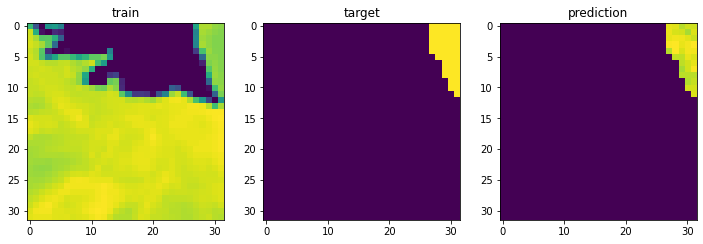

prediction max value =  0.024703778
prediction min value =  2.728938e-12
prediction mean value =  0.0009765624


In [26]:
b = np.reshape(train[test_index], (1, size, size, 1))
prediction = model.predict(b) 
prediction = np.reshape(prediction, (size, size)) 

train_img = np.reshape(train[test_index], (size, size)) 
target_img = np.reshape(target[test_index], (size, size)) 

fig, axes = plt.subplots(1, 3)

axes[0].imshow(train_img)
axes[0].set_title('train')

axes[1].imshow(target_img)
axes[1].set_title('target')

axes[2].imshow(prediction)
axes[2].set_title('prediction')

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()
print("prediction max value = ", prediction.max())
print("prediction min value = ", prediction.min())
print("prediction mean value = ", prediction.mean())

In [96]:
 (prediction*1000).max()

4.0536766

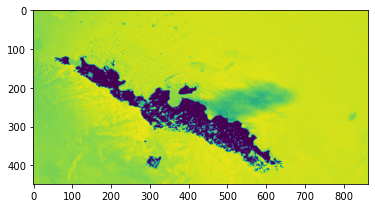

In [76]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        train_img = np.reshape(train[i * train_size[1] + j], (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        
img.save("2.png")
plt.imshow(img) 

100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


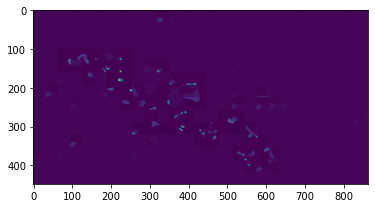

In [32]:
img = Image.new('L', (size*train_size[0], size*train_size[1]))

for i in tqdm(range(train_size[0])):
    for j in range(train_size[1]):

        b = np.reshape(train[i * train_size[1] + j], (1, size, size, 1))
        prediction = model.predict(b)
        prediction = prediction * 5000
        
        train_img = np.reshape(prediction, (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        

plt.imshow(img) 
img.save("1_3_25612890.png")

In [26]:
print(prediction)

[[1.1317295e-09 5.2061274e-08 6.8524901e-07 ... 4.2793651e-08
  1.8844513e-07 7.1384704e-08]
 [1.1396277e-08 2.8596627e-08 3.2344158e-07 ... 2.6575032e-08
  4.8888474e-08 4.6598196e-09]
 [3.1485685e-09 2.5167264e-08 2.2362080e-08 ... 2.2740403e-07
  2.9930806e-07 1.2725336e-07]
 ...
 [2.8482857e-06 2.0997115e-06 1.7216238e-06 ... 1.2906146e-05
  7.5013650e-06 9.0720559e-06]
 [7.6661464e-03 7.4512274e-03 1.2095799e-06 ... 6.9532134e-06
  9.9646077e-06 9.5794658e-06]
 [7.6260320e-03 7.4983542e-03 7.5413492e-03 ... 7.0676970e-06
  5.2254068e-06 6.1871892e-06]]


In [17]:
i = 0
# поиск индекса картинки с маской = 1
while (target[i].max() < 1):
    i+=1
print(i)

31


In [13]:
model_name = "model_3conv512_256_128_inp=32_e=7000"

In [14]:
path = f'models/1/{model_name}.h5'
model.save(path)  

In [63]:
path = f'models/1/{model_name}.h5'
model = tf.keras.models.load_model(path)